In [1]:
from scipy.linalg import block_diag
from scipy.io import loadmat
import autograd.numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ssm

%matplotlib inline

In [2]:
import scipy.io as spio


def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, spio.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, spio.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

In [3]:
num_states = 30
obs_dim = 137

In [4]:
DATA_PATH = '../'
binnedPRE = loadmat(DATA_PATH + 'binnedPBEs_PRE.mat')['binnedPBEs_PRE']
binnedRUN = loadmat(DATA_PATH + 'binnedPBEs_RUN.mat')['binnedPBEs_RUN']
binnedPOST = loadmat(DATA_PATH + 'binnedPBEs_POST.mat')['binnedPBEs_POST']

In [5]:
BDseqscore = loadmat(DATA_PATH + 'BayesianReplayDetection.mat')['BDseqscore']

prctilePOST = np.array(BDseqscore['POST']['data']['wPBEtimeswap']['weightedCorr']['prctilescore'])
prctilePRE = np.array(BDseqscore['PRE']['data']['wPBEtimeswap']['weightedCorr']['prctilescore'])
prctileRUN = np.array(BDseqscore['RUN']['data']['wPBEtimeswap']['weightedCorr']['prctilescore'])
del BDseqscore

In [6]:
thresholds = [99,98,97,95,90,85,80,70,60,50]

# test set creation
threshold = 50
testDataFrac = 0.25
restrictedDataPOST = binnedPOST[np.where(prctilePOST < threshold),:]
restrictedDataPRE = binnedPRE[np.where(prctilePRE < threshold),:]
restrictedDataRUN = binnedRUN[np.where(prctileRUN < threshold),:]

restrictedEvents = np.concatenate((restrictedDataPRE,
                    restrictedDataRUN,
                    restrictedDataPOST), axis = 1).squeeze()

ref50Indices = restrictedEvents[:,2]
numTest = int(restrictedEvents.shape[0]*testDataFrac)
testPBEIndices = np.random.choice(ref50Indices, numTest)


testIndices = testPBEIndices[np.where(np.isin(testPBEIndices, restrictedEvents[:,2]))].astype('uint8')
testData = restrictedEvents[testIndices,:]

In [55]:
hmms = []
thresholds = [50]
for threshold in thresholds:
    
    restrictedDataPOST = binnedPOST[np.where(prctilePOST < threshold),:]
    restrictedDataPRE = binnedPRE[np.where(prctilePRE < threshold),:]
    restrictedDataRUN = binnedRUN[np.where(prctileRUN < threshold),:]

    restrictedEvents = np.concatenate((restrictedDataPRE,
                    restrictedDataRUN,
                    restrictedDataPOST), axis = 1).squeeze()
                    
    testIndices = np.where(~np.isin(restrictedEvents[:,2], testPBEIndices))[0]
    restrictedEvents = restrictedEvents[testIndices,:]
    trainPBEIndices = restrictedEvents[:,2]
    
    numPBEs = restrictedEvents.shape[0]               
    numTrain = int((1-testDataFrac)*numPBEs)
    trainData = restrictedEvents[:numTrain]
    
    d = np.concatenate([x[1].T.astype(np.int8) for x in trainData]).astype(int)
    
    data = d
    N_iters = 50


    ## testing the constrained transitions class
#     hmm = ssm.HMM(num_states, obs_dim, observations="poisson")

#     hmm_lls = hmm.fit(data, method="em", num_iters=N_iters, init_method="kmeans")
    
#     hmms.append({'thr': threshold, 'hmm': hmm})

    y = d
    N = obs_dim
    K = 5
    D = 2

    print("Fitting SLDS with BBVI")
    slds = ssm.SLDS(N, K, D, emissions="poisson_orthog", emission_kwargs=dict(link="softplus"))
    
    q_bbvi_elbos, q_bbvi = slds.fit(y, method="bbvi", 
                                  variational_posterior="tridiag",
                                  initial_variance=1,
                                  num_iters=1000, print_intvl=100, initialize=False)
    q_bbvi_x = q_bbvi.mean[0]

    # Find the permutation that matches the true and inferred states
#     slds.permute(find_permutation(z, slds.most_likely_states(q_bbvi_x, y)))
    q_bbvi_z = slds.most_likely_states(q_bbvi_x, y)

    # Smooth the observations
    q_bbvi_y = slds.smooth(q_bbvi_x, y)
    

Fitting SLDS with BBVI


In [58]:
import pickle
pickle.dump([q_bbvi_elbos, q_bbvi, slds], open(DATA_PATH + f'slds_po_bbvi_50.pkl', "wb" ) )

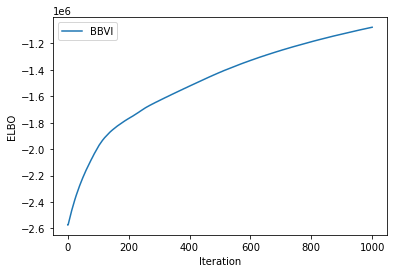

In [56]:
plt.plot(q_bbvi_elbos, label="BBVI")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.legend()

In [8]:
import pickle
# pickle.dump(hmms, open(DATA_PATH + f'HMMtrainingReplayQuality/sameTestData/HMMReplayQuality_ssmpy.pkl', "wb" ) )
hmms = pickle.load(open(DATA_PATH + f'HMMtrainingReplayQuality/sameTestData/HMMReplayQuality_ssmpy.pkl', "rb" ) )

In [9]:
hmms

[{'thr': 99, 'hmm': <ssm.hmm.HMM at 0x7ff883640908>},
 {'thr': 98, 'hmm': <ssm.hmm.HMM at 0x7ff883640128>},
 {'thr': 97, 'hmm': <ssm.hmm.HMM at 0x7ff8836405f8>},
 {'thr': 95, 'hmm': <ssm.hmm.HMM at 0x7ff8bc08acf8>},
 {'thr': 90, 'hmm': <ssm.hmm.HMM at 0x7ff882eace48>},
 {'thr': 85, 'hmm': <ssm.hmm.HMM at 0x7ff882eacf98>},
 {'thr': 80, 'hmm': <ssm.hmm.HMM at 0x7ff883924668>},
 {'thr': 70, 'hmm': <ssm.hmm.HMM at 0x7ff8839246d8>},
 {'thr': 60, 'hmm': <ssm.hmm.HMM at 0x7ff8839240b8>},
 {'thr': 50, 'hmm': <ssm.hmm.HMM at 0x7ff883924b00>}]

In [17]:
r = hmms[0]['hmm'].sample(T=4)

In [19]:
r[1].shape

(4, 137)

In [ ]:
# Fit an rSLDS with its default initialization, using Laplace-EM with a structured variational posterior
rslds = ssm.SLDS(D_obs, K, D_latent,
             transitions="recurrent_only",
             dynamics="diagonal_gaussian",
             emissions="gaussian_orthog",
             single_subspace=True)
rslds.initialize(y)
q_elbos_lem, q_lem = rslds.fit(y, method="laplace_em",
                               variational_posterior="structured_meanfield",
                               initialize=False, num_iters=100, alpha=0.0)

In [ ]:
print("Fitting SLDS with BBVI")
slds = ssm.SLDS(N, K, D, emissions="poisson_orthog", emission_kwargs=dict(link="softplus"))
slds.initialize(y_masked, masks=mask)

q_bbvi_elbos, q_bbvi = slds.fit(y_masked, masks=mask, method="bbvi", 
                              variational_posterior="tridiag",
                              initial_variance=1,
                              num_iters=1000, print_intvl=100, initialize=False)
q_bbvi_x = q_bbvi.mean[0]

# Find the permutation that matches the true and inferred states
slds.permute(find_permutation(z, slds.most_likely_states(q_bbvi_x, y)))
q_bbvi_z = slds.most_likely_states(q_bbvi_x, y)

# Smooth the observations
q_bbvi_y = slds.smooth(q_bbvi_x, y)

In [159]:
import copy
from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap

colors = sns.color_palette(n_colors=num_states)
cmap = gradient_cmap(colors)

def compare_seq(hmm1, hmm2, obs):
    viterbi1 = hmm1.most_likely_states(obs)
    viterbi2 = hmm2.most_likely_states(obs)
    
    hmm2_copy = copy.deepcopy(hmm2)
    
    hmm2.permute(find_permutation(viterbi1, viterbi2, num_states, num_states))
    
    # Plot the true and inferred discrete states
    time_bins = len(obs)
    hmm_z = hmm2.most_likely_states(obs)

    plt.figure(figsize=(8, 4))
    plt.subplot(211)
    plt.imshow(viterbi1[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
    plt.xlim(0, time_bins)
    plt.ylabel("$z_{\\mathrm{true}}$")
    plt.yticks([])

    plt.subplot(212)
    plt.imshow(hmm_z[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
    plt.xlim(0, time_bins)
    plt.ylabel("$z_{\\mathrm{inferred}}$")
    plt.yticks([])
    plt.xlabel("time")

    plt.tight_layout()

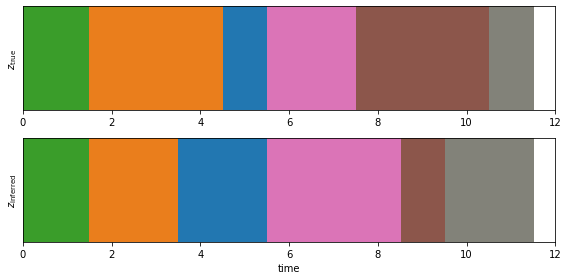

In [161]:
td = [x[1].T.astype(np.int8) for x in testData]

obs = td[10]

compare_seq(hmms[0]['hmm'], hmms[1]['hmm'], obs)

## Average overlap between different percentiles

In [168]:
from ssm.util import compute_state_overlap
def overlap(seq1, seq2):
    overlap = compute_state_overlap(seq1, seq2, num_states, num_states)
    return sum(sum(overlap))

In [169]:
overlap(viterbi50, viterbi99)

26.0

In [188]:
overlaps = []
import itertools

for hmm1_obj, hmm2_obj in itertools.combinations(hmms, r = 2):
        hmm1 = hmm1_obj['hmm']
        hmm2 = hmm2_obj['hmm']
        temp_overlaps = []
        print(hmm1_obj, hmm2_obj)
        for obs in td:
            viterbi1 = hmm1.most_likely_states(obs)
            viterbi2 = hmm2.most_likely_states(obs)

            hmm2_copy = copy.deepcopy(hmm2)

            hmm2_copy.permute(find_permutation(viterbi1, viterbi2, num_states, num_states))
            viterbi2_perm = hmm2_copy.most_likely_states(obs)
            
            over = overlap(viterbi1, viterbi2_perm)
            temp_overlaps.append(over)
            
        print(temp_overlaps)
        overlaps.append({'overlap': temp_overlaps, 'thr1': hmm1_obj['thr'], 'thr2': hmm2_obj['thr']})

{'thr': 99, 'hmm': <ssm.hmm.HMM object at 0x7fca2d31d6d8>} {'thr': 98, 'hmm': <ssm.hmm.HMM object at 0x7fca2cd22f98>}
[26.0, 23.0, 12.0, 9.0, 14.0, 7.0, 16.0, 9.0, 8.0, 11.0, 12.0, 6.0, 12.0, 10.0, 6.0, 5.0, 6.0, 11.0, 7.0, 8.0, 13.0, 6.0, 3.0, 16.0, 16.0, 9.0, 4.0, 10.0, 13.0, 6.0, 5.0, 4.0, 7.0, 7.0, 7.0, 19.0, 10.0, 12.0, 5.0, 14.0, 7.0, 4.0, 6.0, 7.0, 5.0, 6.0, 9.0, 10.0, 8.0, 12.0, 8.0, 10.0, 9.0, 7.0, 11.0, 14.0, 8.0, 13.0, 4.0, 8.0, 9.0, 11.0, 12.0, 9.0, 6.0, 19.0, 5.0, 16.0, 9.0, 10.0, 5.0, 8.0, 4.0, 23.0, 9.0, 8.0, 11.0, 5.0, 21.0, 15.0, 10.0, 6.0, 8.0, 24.0, 3.0, 6.0, 6.0, 16.0, 9.0, 7.0, 5.0, 15.0, 10.0, 5.0, 9.0, 10.0, 7.0, 8.0, 9.0, 19.0, 10.0, 5.0, 4.0, 7.0, 5.0, 5.0, 9.0, 48.0, 5.0, 4.0, 9.0, 4.0, 14.0, 5.0, 6.0, 26.0, 9.0, 19.0, 13.0, 5.0, 5.0, 6.0, 6.0, 18.0, 4.0, 8.0, 7.0, 7.0, 9.0, 12.0, 20.0, 26.0, 5.0, 9.0, 9.0, 19.0, 9.0, 21.0, 10.0, 10.0, 11.0, 14.0, 12.0, 5.0, 8.0, 11.0, 5.0, 9.0, 4.0, 6.0, 8.0, 4.0, 7.0, 7.0, 11.0, 4.0, 6.0, 4.0, 14.0, 13.0, 6.0, 5.0, 9.0, 17.0

KeyboardInterrupt: 

In [194]:
overlaps[1]['overlap']

[26.0,
 23.0,
 12.0,
 9.0,
 14.0,
 7.0,
 16.0,
 9.0,
 8.0,
 11.0,
 12.0,
 6.0,
 12.0,
 10.0,
 6.0,
 5.0,
 6.0,
 11.0,
 7.0,
 8.0,
 13.0,
 6.0,
 3.0,
 16.0,
 16.0,
 9.0,
 4.0,
 10.0,
 13.0,
 6.0,
 5.0,
 4.0,
 7.0,
 7.0,
 7.0,
 19.0,
 10.0,
 12.0,
 5.0,
 14.0,
 7.0,
 4.0,
 6.0,
 7.0,
 5.0,
 6.0,
 9.0,
 10.0,
 8.0,
 12.0,
 8.0,
 10.0,
 9.0,
 7.0,
 11.0,
 14.0,
 8.0,
 13.0,
 4.0,
 8.0,
 9.0,
 11.0,
 12.0,
 9.0,
 6.0,
 19.0,
 5.0,
 16.0,
 9.0,
 10.0,
 5.0,
 8.0,
 4.0,
 23.0,
 9.0,
 8.0,
 11.0,
 5.0,
 21.0,
 15.0,
 10.0,
 6.0,
 8.0,
 24.0,
 3.0,
 6.0,
 6.0,
 16.0,
 9.0,
 7.0,
 5.0,
 15.0,
 10.0,
 5.0,
 9.0,
 10.0,
 7.0,
 8.0,
 9.0,
 19.0,
 10.0,
 5.0,
 4.0,
 7.0,
 5.0,
 5.0,
 9.0,
 48.0,
 5.0,
 4.0,
 9.0,
 4.0,
 14.0,
 5.0,
 6.0,
 26.0,
 9.0,
 19.0,
 13.0,
 5.0,
 5.0,
 6.0,
 6.0,
 18.0,
 4.0,
 8.0,
 7.0,
 7.0,
 9.0,
 12.0,
 20.0,
 26.0,
 5.0,
 9.0,
 9.0,
 19.0,
 9.0,
 21.0,
 10.0,
 10.0,
 11.0,
 14.0,
 12.0,
 5.0,
 8.0,
 11.0,
 5.0,
 9.0,
 4.0,
 6.0,
 8.0,
 4.0,
 7.0,
 7.0,
 11.0,
 4.0,
 6.0